In [1]:
import pandas as pd
from deep_translator import GoogleTranslator
from tqdm import tqdm
from transformers import AutoTokenizer, AutoModel, TFAutoModel
import torch
import numpy as np
import re
import nltk
from nltk.corpus import stopwords
import matplotlib.pyplot as plt
import ollama
from concurrent.futures import ThreadPoolExecutor, as_completed
from collections import Counter
import os
import glob
import string
from nltk.corpus import stopwords
from itertools import product
import json
from scipy.stats import shapiro, spearmanr, pearsonr
import seaborn as sns
import dcor
import scipy.stats as stats
from datetime import timedelta
from statsmodels.graphics.tsaplots import plot_acf
from pathlib import Path


#matplotlib
import matplotlib.pyplot as plt
import matplotlib.dates as mdates

#sklearn
from sklearn.model_selection import train_test_split
from sklearn.ensemble import RandomForestClassifier
from sklearn.model_selection import train_test_split
from sklearn.metrics import accuracy_score, classification_report, roc_auc_score
from sklearn.preprocessing import StandardScaler, PolynomialFeatures
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import accuracy_score
from sklearn.neighbors import KNeighborsClassifier
from sklearn.decomposition import PCA
from sklearn.model_selection import GridSearchCV
from sklearn.pipeline import Pipeline
from sklearn.preprocessing import MinMaxScaler, RobustScaler
from sklearn.metrics import accuracy_score

#xgboost
import xgboost as xgb
from xgboost import XGBClassifier

# Annotatie niet doen, want het heeft GPU nodig en duurt ongeveer een dag

## Data laden

combined = pd.read_csv("data/combined.csv")

## Data schoonmaken

def clean_text(text):
    # Remove RT @user: or RT
    text = re.sub(r'\bRT\s+@\w+:', '', text)
    text = re.sub(r'^\s*RT\b', '', text)
    
    # Remove @'s
    text = re.sub(r'@\w+', '', text)
    
    # Remove hashtags #, alleen de # #hashtag -> hashtag
    text = re.sub(r'#', '', text)
    
    # Remove URLs (http, https, www, .com, etc.)
    text = re.sub(r'http\S+|www\.\S+|\S+\.com\S*', '', text)
    
    # Remove punctuation
    text = text.translate(str.maketrans('', '', string.punctuation))
    
    # Remove emojis and other non-ASCII characters
    text = text.encode('ascii', 'ignore').decode('ascii')
    
    # Remove extra whitespace
    text = re.sub(r'\s+', ' ', text).strip()
    
    return text

combined['fullText'] = combined['fullText'].astype(str).apply(clean_text) 

# Annotatie

os.environ["OLLAMA_GPU"] = "1"

df = combined.copy()

def analyze_tweet(tweet):
    prompt = f"""
    You are a twitter sentiment annotation bot for Dutch tweets. 
    You must ONLY respond with:
    - One of: 'highly positive', 'positive', 'neutral', 'negative' or ' highly negative'
    - And the Dutch political party it targets:
        - 'PVV' (Partij voor de Vrijheid led by Geert Wilders)
        - 'D66' (Democraten66 led by Rob Jetten)
        - 'None' if no political target is clear or it’s non-political
        - 'both' if both are mentioned
    Given the tweet: "{tweet}", what is this tweet's sentiment and which party does it target? Remember, only respond in format: sentiment (positive/negative/neutral),targeted_party(PVV/D66/Both/None)
    ONLY USE THE GIVEN FORMAT AS ANSWER
    """

    try:
        response = ollama.chat(
            model="qwen3",
            messages=[{"role": "user", "content": prompt}],
            )
        return response["message"]["content"].strip()
    except Exception as e:
        return f"error: {e}"

results = []
with ThreadPoolExecutor(max_workers=3) as executor:  
    futures = {executor.submit(analyze_tweet, t): i for i, t in enumerate(df["fullText"])}

    for future in tqdm(as_completed(futures), total=len(futures), desc="Annotating tweets (parallel GPU)"):
        results.append(future.result())

df["analysis"] = results

qwen = df.copy()
qwen.to_csv("data\qwen3.csv", index=False)

## Checkpoint

In [2]:
raw = pd.read_csv("data/qwen3.csv")

## Streamline output

In [3]:
raw = raw.copy()
# Split the 'analysis' column into exactly two columns
raw[['sentiment', 'party_target']] = (
    raw['analysis']
    .str.split(',', n=1, expand=True)
)

# Strip whitespace from both new columns
raw[['sentiment', 'party_target']] = (
    raw[['sentiment', 'party_target']].apply(lambda col: col.str.strip())
)
raw = raw.drop(columns=['analysis']) # drop origineel

mapping = {
    # neutral
    "neutral": 0,
    "Neutral": 0,
    "'Neutral'": 0,

    # negative
    "negative": -1,
    "Negative": -1,
    "'Negative'": -1,

    # highly negative
    "highly negative": -2,
    "Highly negative": -2,
    "Highly Negative": -2,

    # positive
    "positive": 1,
    "Positive": 1,
    "'Positive'": 1,

    # highly positive
    "highly positive": 2,
    "Highly positive": 2,
    "Highly Positive": 2,
    "'Highly positive'": 2,
    "'Highly Positive'": 2,
}


# map using the dictionary
raw["sentiment"] = raw["sentiment"].map(mapping)

# Handmatig, want fout tijdens analyse
nan_index = raw[raw["sentiment"].isna()].index
raw.loc[nan_index, 'sentiment'] = 0
raw.loc[nan_index, 'party_target'] = 'None'

# Convert to int
raw["sentiment"] = raw["sentiment"].astype(int)
#----------------------------------------------------------------
#target_party

def clean_party_target(value):
    if pd.isna(value):
        return 'None'

    # Convert to lowercase for easier matching
    val = str(value).lower()

    # Match PVV
    if re.search(r'\bpvv\b', val):
        return 'PVV'
    # Match D66
    if re.search(r'\bd66\b', val):
        return 'D66'

    # Match Both
    if re.search(r'\bboth\b', val):
        return 'Both'

    # Match None-like
    if re.search(r'\bnone\b', val):
        return 'None'

    # Anything else -> None
    return 'None'
raw['party_target'] = raw['party_target'].apply(clean_party_target) # apply
raw.index = range(len(raw)) # reset index

display(raw)
print("(sentiment) Gewenste hvl categorieeen? " + str(len(Counter(raw['sentiment']).keys()) == 5))
print("(sentiment) Goede categorieen? " + str(set(Counter(raw['sentiment']).keys()) == {0, -1, 1, -2, 2}))
print("(sentiment) " + str(Counter(raw['sentiment'])))
print("-------------------------------------------------------------------------------------------")
print("(party target) Gewenste hvl categorieeen? " + str(len(Counter(raw['party_target']).keys()) == 4))
print("(party target) Goede categorieen? " + str(set(Counter(raw['party_target']).keys()) == {'None', 'PVV', 'D66', 'Both'}))
print("(party target) " + str(Counter(raw['party_target'])))

,author/followers,author/following,bookmarkCount,createdAt,fullText,viewCount,retweetCount,replyCount,quoteCount,likeCount,sentiment,party_target
0,434,346,10,19 augustus,Antibiotica is toch tegen bacterile infecties ...,4909,203,125,37,680,0,None
1,9532,2340,798,14 augustus,China is playing the long term game here and l...,93226,946,355,135,1333,0,None
2,684,472,28,8 augustus,Zo is het,24372,1239,505,98,9819,0,Both
3,503,489,22,8 augustus,Zal er zo iets over zeggen in,16180,403,53,34,1598,0,Both
4,111,166,8,19 augustus,Dit dus De drukte in de teststraten is 1 grote...,7801,9,53,25,72,0,Both
...,...,...,...,...,...,...,...,...,...,...,...,...
31027,881,991,72,15 september,Ja meneer presedent In 26 jaar het julle colle...,3934,335,297,111,1561,-1,None
31028,176,293,17,29 september,Schone wc belangrijk Jouw bedrijfstoilet reini...,378,45,153,69,86,0,None
31029,2330,1537,172,15 september,Yes it has arrived We can not trust Trumps res...,9632,819,527,147,6117,0,Both
31030,612,815,37,13 september,Een campingtour is lang zo kneuterig niet Even...,1373,149,204,81,776,0,None


(sentiment) Gewenste hvl categorieeen? True
(sentiment) Goede categorieen? True
(sentiment) Counter({0: 20877, -1: 7039, 1: 2344, 2: 710, -2: 62})
-------------------------------------------------------------------------------------------
(party target) Gewenste hvl categorieeen? True
(party target) Goede categorieen? True
(party target) Counter({'None': 17305, 'PVV': 6175, 'Both': 5304, 'D66': 2248})


# Bot detectie

In [4]:
tokenizer = AutoTokenizer.from_pretrained("pdelobelle/robbert-v2-dutch-base")
model = AutoModel.from_pretrained("pdelobelle/robbert-v2-dutch-base")
#print(model.eval())

if tokenizer.pad_token is None:
    tokenizer.pad_token = tokenizer.eos_token

#CUDA TEST
print(torch.version.cuda)         # Should print your CUDA version (e.g., 12.1)
print(torch.backends.cudnn.enabled)  # Should be True
print(torch.cuda.is_available())   # Should be True

device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
print("Using device:", device)

# Move model to GPU
model.to(device)

Some weights of RobertaModel were not initialized from the model checkpoint at pdelobelle/robbert-v2-dutch-base and are newly initialized: ['pooler.dense.bias', 'pooler.dense.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


13.0
True
True
Using device: cuda


RobertaModel(
  (embeddings): RobertaEmbeddings(
    (word_embeddings): Embedding(40000, 768, padding_idx=1)
    (position_embeddings): Embedding(514, 768, padding_idx=1)
    (token_type_embeddings): Embedding(1, 768)
    (LayerNorm): LayerNorm((768,), eps=1e-05, elementwise_affine=True)
    (dropout): Dropout(p=0.1, inplace=False)
  )
  (encoder): RobertaEncoder(
    (layer): ModuleList(
      (0-11): 12 x RobertaLayer(
        (attention): RobertaAttention(
          (self): RobertaSdpaSelfAttention(
            (query): Linear(in_features=768, out_features=768, bias=True)
            (key): Linear(in_features=768, out_features=768, bias=True)
            (value): Linear(in_features=768, out_features=768, bias=True)
            (dropout): Dropout(p=0.1, inplace=False)
          )
          (output): RobertaSelfOutput(
            (dense): Linear(in_features=768, out_features=768, bias=True)
            (LayerNorm): LayerNorm((768,), eps=1e-05, elementwise_affine=True)
            (dr

## Checkpoint

In [5]:
X_base = pd.read_csv("data/extern100_features.csv")
y_base = pd.read_csv("data/extern100_labels.csv")

## Handmatige 100 annotatie

In [6]:
#splitten + 100 handmatig sample
X = X_base.copy()
y = y_base.copy()
cols = [col for col in X.columns if col != "fullText"] + ["fullText"]  # zorg ervoor fullText laatst
X = X[cols] # zorg ervoor fullText laatst
X['viewCount'] = (
    pd.to_numeric(X['viewCount'], errors='coerce')
        .fillna(0)
        .astype(int)
) # maak andere soort char/whitespace -> int
X['viewCount'] = X['viewCount'].astype(int) #normaal naar int
X = X.drop(['createdAt', 'party_target','sentiment'], axis=1)

#--------------------------------------------------------
#extra filter stopwoorden voordat XGBoost
eng_stop = set(stopwords.words("english"))
nl_stop = set(stopwords.words("dutch"))
all_stopwords = eng_stop.union(nl_stop)

# Build regex for stopwords (word boundaries)
stopword_regex = r'\b(?:' + '|'.join(re.escape(w) for w in all_stopwords) + r')\b'

def clean_text(text):
    if not isinstance(text, str):
        return ""
    
    # Lowercase
    text = text.lower()

    # Remove stopwords
    text = re.sub(stopword_regex, ' ', text)

    # Remove punctuation & digits
    text = re.sub(r'[^a-zA-Záéíóúàèùäëïöüçñß]', ' ', text)

    # Remove short tokens (1 character)
    text = re.sub(r'\b\w{1}\b', ' ', text)

    # Normalize whitespace
    text = re.sub(r'\s+', ' ', text).strip()

    return text

X["fullText"] = X["fullText"].apply(clean_text)
#--------------------------------------------------------
print("Zelfde size 100x100 voor X en y?: " + str(X.shape[0] == y.shape[0]))
print("Bots:", y["bot"].sum())
print("Humans:", (y["bot"] == 0).sum())

Zelfde size 100x100 voor X en y?: True
Bots: 12
Humans: 88


In [7]:
def get_embeddings(text_list, tokenizer, model, batch_size=120, device='cuda'):
    all_embeddings = []

    if isinstance(text_list, pd.Series):
        index = text_list.index
        text_list = text_list.tolist()
    else:
        index = range(len(text_list))

    for i in tqdm(range(0, len(text_list), batch_size), desc="Generating embeddings"):
        batch_texts = text_list[i:i+batch_size]

        #tokenize zonder tensors voor lengtes
        tokenized = [tokenizer.encode(text, add_special_tokens=True) for text in batch_texts]
        lengths = [len(t) for t in tokenized]
        median_len = int(np.median(lengths))

        #padding/truncation naar median length
        encoded = tokenizer(
            batch_texts,
            padding='max_length',
            truncation=True,
            max_length=median_len,
            return_tensors='pt'
        )

        # Move all tensors to the same device
        encoded = {k: v.to(device) for k, v in encoded.items()}

        with torch.no_grad():
            outputs = model(**encoded)

        hidden_states = outputs.last_hidden_state  # [batch, seq_len, hidden_dim]
        mask = encoded['attention_mask'].unsqueeze(-1)  # make same device

        # Mean pooling ignoring padding
        sum_embeddings = (hidden_states * mask).sum(dim=1)
        lengths_masked = mask.sum(dim=1)
        batch_embeddings = (sum_embeddings / lengths_masked).cpu().numpy()

        all_embeddings.append(batch_embeddings)

    embeddings = np.vstack(all_embeddings)
    return pd.DataFrame(embeddings, index=index)

embeddings = get_embeddings(X['fullText'], tokenizer, model, batch_size=120, device='cuda') 
print(embeddings.shape)
X = pd.concat([X.drop(['fullText'], axis=1), embeddings], axis=1)
print(X.shape)

#train model zelf
X_train, X_test, y_train, y_test = train_test_split(X, y, random_state=42, stratify=y, test_size=0.2) 


param_grid = {
    'max_depth': [4, 6, 8],
    'learning_rate': [0.01, 0.05, 0.1],
    'n_estimators': [100, 300, 500],
    'subsample': [0.8, 1.0],
    'colsample_bytree': [0.8, 1.0]
}

# Create DMatrix objects for GPU
dtrain = xgb.DMatrix(X_train, label=y_train)
dtest = xgb.DMatrix(X_test, label=y_test)


results = []
best_score = 0
best_params = None

# Grid search
total_combinations = np.prod([len(v) for v in param_grid.values()])
print(f"Testing {total_combinations} parameter combinations...")

for i, (max_depth, learning_rate, n_estimators, subsample, colsample_bytree) in enumerate(
    product(
        param_grid['max_depth'],
        param_grid['learning_rate'],
        param_grid['n_estimators'],
        param_grid['subsample'],
        param_grid['colsample_bytree']
    ), 1
):
    
    params = {
        'device': 'cuda',
        'tree_method': 'hist',
        'eval_metric': 'logloss',
        'objective': 'binary:logistic',
        'max_depth': max_depth,
        'learning_rate': learning_rate,
        'subsample': subsample,
        'colsample_bytree': colsample_bytree
    }
    
    # Train model
    bst = xgb.train(
        params,
        dtrain,
        n_estimators,
        evals=[(dtest, 'test')],
        verbose_eval=False
    )
    
    # Predict
    y_pred_proba = bst.predict(dtest)
    y_pred = (y_pred_proba > 0.5).astype(int)
    
    # Eval
    accuracy = accuracy_score(y_test, y_pred)
    auc = roc_auc_score(y_test, y_pred_proba)
    
    
    results.append({
        'max_depth': max_depth,
        'learning_rate': learning_rate,
        'n_estimators': n_estimators,
        'subsample': subsample,
        'colsample_bytree': colsample_bytree,
        'accuracy': accuracy,
        'auc': auc
    })
    
    #best model
    if accuracy > best_score:
        best_score = accuracy
        best_params = params.copy()
        best_params['n_estimators'] = n_estimators
        best_model = bst
    
    print(f"[{i}/{total_combinations}] max_depth={max_depth}, lr={learning_rate}, "
          f"n_est={n_estimators}, subsample={subsample}, colsample={colsample_bytree} "
          f"→ Acc: {accuracy:.4f}, AUC: {auc:.4f}")


print("\n" + "="*80)
print("BEST PARAMETERS:")
print("="*80)
for key, value in best_params.items():
    print(f"{key}: {value}")
print(f"\nBest Accuracy: {best_score:.4f}")


print("\n" + "="*80)
print("TRAINING FINAL MODEL WITH BEST PARAMETERS...")
print("="*80)
final_bst = xgb.train(
    {k: v for k, v in best_params.items() if k != 'n_estimators'},
    dtrain,
    best_params['n_estimators'],
    evals=[(dtest, 'test')]
)

# Final 
y_pred_proba = final_bst.predict(dtest)
y_pred = (y_pred_proba > 0.5).astype(int)

print("\nFINAL MODEL PERFORMANCE:")
print("Accuracy:", accuracy_score(y_test, y_pred))
print("\n" + classification_report(y_test, y_pred))

Generating embeddings: 100%|█████████████████████████████████████████████████████████████| 1/1 [00:00<00:00,  1.21it/s]


(100, 768)
(100, 776)
Testing 108 parameter combinations...
[1/108] max_depth=4, lr=0.01, n_est=100, subsample=0.8, colsample=0.8 → Acc: 0.9000, AUC: 1.0000
[2/108] max_depth=4, lr=0.01, n_est=100, subsample=0.8, colsample=1.0 → Acc: 0.9000, AUC: 1.0000
[3/108] max_depth=4, lr=0.01, n_est=100, subsample=1.0, colsample=0.8 → Acc: 0.9000, AUC: 1.0000
[4/108] max_depth=4, lr=0.01, n_est=100, subsample=1.0, colsample=1.0 → Acc: 0.9000, AUC: 1.0000
[5/108] max_depth=4, lr=0.01, n_est=300, subsample=0.8, colsample=0.8 → Acc: 0.9000, AUC: 1.0000
[6/108] max_depth=4, lr=0.01, n_est=300, subsample=0.8, colsample=1.0 → Acc: 0.9000, AUC: 1.0000
[7/108] max_depth=4, lr=0.01, n_est=300, subsample=1.0, colsample=0.8 → Acc: 0.9500, AUC: 1.0000
[8/108] max_depth=4, lr=0.01, n_est=300, subsample=1.0, colsample=1.0 → Acc: 0.9500, AUC: 1.0000
[9/108] max_depth=4, lr=0.01, n_est=500, subsample=0.8, colsample=0.8 → Acc: 0.9000, AUC: 1.0000
[10/108] max_depth=4, lr=0.01, n_est=500, subsample=0.8, colsample=

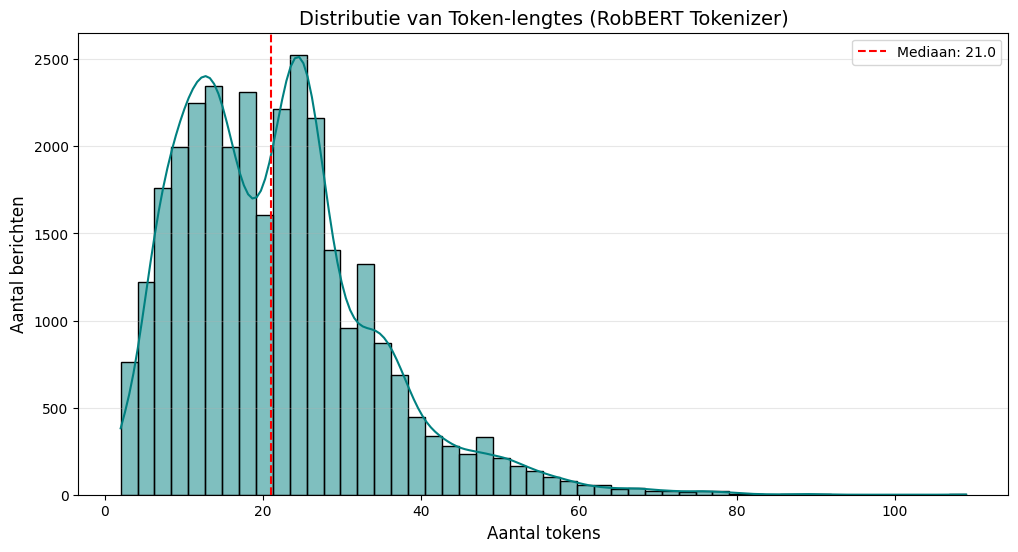

De gemiddelde lengte is: 21.64
De mediaan lengte is: 21.0


In [8]:
# 1. Zorg dat de tekst uit het originele frame voor naar string
texts = raw['fullText'].fillna("").astype(str).tolist()

# 2. Bereken de lengte van de tokens voor elk bericht
token_lengths = [len(tokenizer.encode(text)) for text in texts]

# 3. Plot de distributie
plt.figure(figsize=(12, 6))
sns.histplot(token_lengths, bins=50, kde=True, color='teal')

# Bereken en teken de mediaan
median_length = pd.Series(token_lengths).median()
plt.axvline(median_length, color='red', linestyle='--', label=f'Mediaan: {median_length}')

plt.title("Distributie van Token-lengtes (RobBERT Tokenizer)", fontsize=14)
plt.xlabel("Aantal tokens", fontsize=12)
plt.ylabel("Aantal berichten", fontsize=12)
plt.legend()

filepath = r"image\Distributie token hvlheid.png"

# Make sure the directory exists
os.makedirs(os.path.dirname(filepath), exist_ok=True)

# Save figure
plt.savefig(filepath, dpi=300, bbox_inches='tight')

plt.grid(axis='y', alpha=0.3)
plt.show()

print(f"De gemiddelde lengte is: {pd.Series(token_lengths).mean():.2f}")
print(f"De mediaan lengte is: {median_length}")

In [9]:
save_dir = "ml_models"

model_path = os.path.join(save_dir, 'best_xgboost_model.json')
final_bst.save_model(model_path)
print(f"\n✓ Model saved: {model_path}")

#best parameters
params_path = os.path.join(save_dir, 'best_params.json')
with open(params_path, 'w') as f:
    json.dump(best_params, f, indent=4)
print(f"✓ Parameters saved: {params_path}")

#all results
results_path = os.path.join(save_dir, 'gridsearch_results.csv')
results_df = pd.DataFrame(results).sort_values('accuracy', ascending=False)
results_df.to_csv(results_path, index=False)
print(f"✓ Grid search results saved: {results_path}")

print(f"\nAll files saved to: {save_dir}")


✓ Model saved: ml_models\best_xgboost_model.json
✓ Parameters saved: ml_models\best_params.json
✓ Grid search results saved: ml_models\gridsearch_results.csv

All files saved to: ml_models


In [10]:
save_dir = 'ml_models'

model_path = os.path.join(save_dir, 'best_xgboost_model.json')
loaded_bst = xgb.Booster()
loaded_bst.load_model(model_path)
print(f"✓ Model loaded from: {model_path}")

# Load the best parameters
params_path = os.path.join(save_dir, 'best_params.json')
with open(params_path, 'r') as f:
    loaded_params = json.load(f)
print(f"✓ Parameters loaded from: {params_path}")
print("\nLoaded parameters:")
for key, value in loaded_params.items():
    print(f"  {key}: {value}")

#--------------------------------------
#Run:
X = raw.copy()
X['viewCount'] = (
    pd.to_numeric(X['viewCount'], errors='coerce')
        .fillna(0)
        .astype(int)
) # maak andere soort char/whitespace -> int
X['viewCount'] = X['viewCount'].astype(int) #normaal naar int
X = X.drop(['createdAt','sentiment','party_target'], axis=1)

X["fullText"] = X["fullText"].apply(clean_text) # clean weer

embeddings = get_embeddings(X['fullText'], tokenizer, model, batch_size=120, device='cuda') # embeddings weer
print(embeddings.shape)
X = pd.concat([X.drop(['fullText'], axis=1), embeddings], axis=1)
print(X.shape)

X_test = X.copy()

dtest = xgb.DMatrix(X_test)
y_pred_proba = loaded_bst.predict(dtest)
y_pred = (y_pred_proba > 0.5).astype(int)

print("\nPredictions completed!")
print(f"Number of predictions: {len(y_pred)}")
print(y_pred)

✓ Model loaded from: ml_models\best_xgboost_model.json
✓ Parameters loaded from: ml_models\best_params.json

Loaded parameters:
  device: cuda
  tree_method: hist
  eval_metric: logloss
  objective: binary:logistic
  max_depth: 4
  learning_rate: 0.01
  subsample: 1.0
  colsample_bytree: 0.8
  n_estimators: 300


Generating embeddings: 100%|█████████████████████████████████████████████████████████| 259/259 [00:18<00:00, 13.69it/s]


(31032, 768)
(31032, 776)

Predictions completed!
Number of predictions: 31032
[0 0 0 ... 0 0 0]


In [11]:
Bot_eind = raw.copy()
Bot_eind['viewCount'] = (
    pd.to_numeric(Bot_eind['viewCount'], errors='coerce')
        .fillna(0)
        .astype(int)
) # maak andere soort char/whitespace -> int
Bot_eind['viewCount'] = Bot_eind['viewCount'].astype(int) #normaal naar int


Bot_eind['bot'] = y_pred # zet bot erbij
Bot_eind['sentiment'], Bot_eind['party_target']  = raw['sentiment'], raw['party_target'] #zet sentiment erbij

display(Bot_eind)
bot_rows = Bot_eind[Bot_eind['bot'] == 1]
display(bot_rows)

month_map = {
'juni': 6,
'juli': 7,
'augustus': 8,
'september': 9,
'oktober': 10
}

def convert_to_datetime(date_str):
    day, month = date_str.split()
    return pd.Timestamp(year=2025, month=month_map[month.lower()], day=int(day))

Bot_eind['createdAt_dt'] = Bot_eind['createdAt'].apply(convert_to_datetime)
Bot_eind['bot'] = y_pred
Bot_eind = Bot_eind.sort_values('createdAt_dt').drop(columns='createdAt_dt')


display(Bot_eind.head(2))
display(Bot_eind.tail(2))
print(Bot_eind.shape)
print(Bot_eind.columns)

,author/followers,author/following,bookmarkCount,createdAt,fullText,viewCount,retweetCount,replyCount,quoteCount,likeCount,sentiment,party_target,bot
0,434,346,10,19 augustus,Antibiotica is toch tegen bacterile infecties ...,4909,203,125,37,680,0,None,0
1,9532,2340,798,14 augustus,China is playing the long term game here and l...,93226,946,355,135,1333,0,None,0
2,684,472,28,8 augustus,Zo is het,24372,1239,505,98,9819,0,Both,0
3,503,489,22,8 augustus,Zal er zo iets over zeggen in,16180,403,53,34,1598,0,Both,0
4,111,166,8,19 augustus,Dit dus De drukte in de teststraten is 1 grote...,7801,9,53,25,72,0,Both,1
...,...,...,...,...,...,...,...,...,...,...,...,...,...
31027,881,991,72,15 september,Ja meneer presedent In 26 jaar het julle colle...,3934,335,297,111,1561,-1,None,0
31028,176,293,17,29 september,Schone wc belangrijk Jouw bedrijfstoilet reini...,378,45,153,69,86,0,None,0
31029,2330,1537,172,15 september,Yes it has arrived We can not trust Trumps res...,9632,819,527,147,6117,0,Both,0
31030,612,815,37,13 september,Een campingtour is lang zo kneuterig niet Even...,1373,149,204,81,776,0,None,0


,author/followers,author/following,bookmarkCount,createdAt,fullText,viewCount,retweetCount,replyCount,quoteCount,likeCount,sentiment,party_target,bot
4,111,166,8,19 augustus,Dit dus De drukte in de teststraten is 1 grote...,7801,9,53,25,72,0,Both,1
8,102,180,7,18 augustus,I remember how at the beginning of the plandem...,2967,19,54,20,110,0,None,1
11,311,402,7,27 augustus,Nach allem was wir hoeren ist das neue Lager b...,2961,113,40,22,487,-1,PVV,1
12,137,68,7,13 augustus,En graag ook internationale samenwerking nu er...,601,43,31,23,122,0,Both,1
20,280,402,11,13 augustus,Are the capable or unwilling to implement a cl...,9801,11,42,23,83,0,None,1
...,...,...,...,...,...,...,...,...,...,...,...,...,...
29456,385,509,4,16 september,Public Health Passenger Locator Form Public He...,3941,194,81,25,817,0,None,1
29483,85,286,3,10 september,Gaat lekker daar in china,2851,114,73,23,408,0,None,1
29492,70,177,3,25 september,Neen dat klopt niet,1783,78,60,24,237,0,None,1
29537,308,486,7,18 september,Er moeten op korte termijn veel tijdelijke woo...,4178,58,70,25,183,0,None,1


,author/followers,author/following,bookmarkCount,createdAt,fullText,viewCount,retweetCount,replyCount,quoteCount,likeCount,sentiment,party_target,bot
12677,45195,3454,11,1 juni,Vlaanderen en Antwerpen kleuren oranje en diep...,312454,3211,896,195,22190,0,None,0
12970,170,143,9,1 juni,Goed advies is dit Wij hebben in totaal een uu...,21456,5215,4218,2150,12455,0,None,0


,author/followers,author/following,bookmarkCount,createdAt,fullText,viewCount,retweetCount,replyCount,quoteCount,likeCount,sentiment,party_target,bot
17893,23412,7821,7,27 oktober,Alleen Geert durft het te zeggen,45678,567,234,56,4567,-1,PVV,0
17910,23412,3451,31,27 oktober,Wilders is onze laatste kans,234567,4123,1567,298,27841,2,PVV,0


(31032, 13)
Index(['author/followers', 'author/following', 'bookmarkCount', 'createdAt',
       'fullText', 'viewCount', 'retweetCount', 'replyCount', 'quoteCount',
       'likeCount', 'sentiment', 'party_target', 'bot'],
      dtype='object')


# Analyse

## Laad data

In [12]:
frame = pd.read_csv(r'data/bot_ml.csv')
peilingen = pd.read_excel(r'data/peilingen.xlsx')
peilingen.index = peilingen['date']
peilingen = peilingen.drop(['date'],axis=1)
peilingen = peilingen.loc['2025-06-01' : '2025-11-27']
peilingen = peilingen[['PVV', 'D66']]
display(peilingen)
display(frame)

,PVV,D66
date,,
2025-06-01,0.192488,0.071147
2025-06-02,0.193464,0.071118
2025-06-03,0.194469,0.071078
2025-06-04,0.195394,0.071079
2025-06-05,0.196495,0.071019
...,...,...
2025-10-24,0.176755,0.138306
2025-10-25,0.173856,0.141259
2025-10-26,0.170865,0.144551


,author/followers,author/following,bookmarkCount,createdAt,fullText,viewCount,retweetCount,replyCount,quoteCount,likeCount,bot,sentiment,party_target
0,45195,3454,11,1 juni,Vlaanderen en Antwerpen kleuren oranje en diep...,312454,3211,896,195,22190,0,0,NaN
1,170,143,9,1 juni,Goed advies is dit Wij hebben in totaal een uu...,21456,5215,4218,2150,12455,0,0,NaN
2,524,780,20,1 juni,Uurmmmm,45209,190,93,29,3121,0,0,NaN
3,717,415,42,1 juni,Probleempje voor de Europese Commissie Phil Ho...,9368,93,69,39,489,0,0,NaN
4,160,96,3,1 juni,Dat thuiswerken veroorzaakt nu kennelijk ook a...,1622,99,56,17,219,1,0,Both
...,...,...,...,...,...,...,...,...,...,...,...,...,...
31027,735,873,28,27 oktober,Wat is dit voor dom antwoord Weet je wel hoe v...,22192,77,97,54,487,0,0,NaN
31028,45192,6712,2,27 oktober,Geert Wilders bedankt voor alles,123456,2891,987,187,18921,0,1,PVV
31029,49,105,13,27 oktober,CRISISKOKEN is tot en met 20 mei te bestellen ...,4672,25,85,49,40,0,0,NaN
31030,23412,7821,7,27 oktober,Alleen Geert durft het te zeggen,45678,567,234,56,4567,0,-1,PVV


## Correlatie

In [13]:
# NaN = 0
frame['sentiment'] = frame['sentiment'].fillna(0)

#  mean sentiment + party_target per dag
# Group by both createdAt and party_target, then calculate mean sentiment
sentiment_by_date_party = frame.groupby(['createdAt', 'party_target'])['sentiment'].mean()

# result
print("Sentiment mean by date and party_target:")
print(sentiment_by_date_party)

# Get all unique dates from the dataframe
all_dates = frame['createdAt'].unique()

# Maak pd.Series
try:
    pvv_line = sentiment_by_date_party.xs('PVV', level='party_target')
    # Reindex to include all dates, filling missing with 0
    pvv_line = pvv_line.reindex(all_dates, fill_value=0)
    print("\nPVV sentiment by date:")
    print(pvv_line)
except KeyError:
    print("\nNo PVV data found")
    pvv_line = pd.Series(0, index=all_dates)

try:
    both_line = sentiment_by_date_party.xs('Both', level='party_target')
    # Reindex to include all dates, filling missing with 0
    both_line = both_line.reindex(all_dates, fill_value=0)
    print("\nBoth sentiment by date:")
    print(both_line)
except KeyError:
    print("\nNo Both data found")
    both_line = pd.Series(0, index=all_dates)

try:
    d66_line = sentiment_by_date_party.xs('D66', level='party_target')
    # Reindex to include all dates, filling missing with 0
    d66_line = d66_line.reindex(all_dates, fill_value=0)
    print("\nD66 sentiment by date:")
    print(d66_line)
except KeyError:
    print("\nNo D66 data found")
    d66_line = pd.Series(0, index=all_dates)

# Handle NaN 
try:
    # Get all unique party_target values including NaN
    party_values = frame['party_target'].unique()
    
    # Check Nan
    if any(pd.isna(party_values)):
        # Filter for rows where party_target is NaN
        none_mask = frame['party_target'].isna()
        none_data = frame[none_mask].groupby('createdAt')['sentiment'].mean()
        # Reindex to include all dates, filling missing with 0
        none_line = none_data.reindex(all_dates, fill_value=0)
        print("\nNo target sentiment by date:")
        print(none_line)
    else:
        none_line = pd.Series(0, index=all_dates)
except Exception as e:
    print(f"\nError processing NaN party_target: {e}")
    none_line = pd.Series(0, index=all_dates)

Sentiment mean by date and party_target:
createdAt    party_target
1 augustus   Both            0.000000
             D66            -0.235294
             PVV            -0.853659
1 juli       Both           -0.052632
             D66             0.125000
                               ...   
9 oktober    D66            -0.405797
             PVV            -0.017699
9 september  Both            0.000000
             D66            -0.181818
             PVV            -0.804878
Name: sentiment, Length: 441, dtype: float64

PVV sentiment by date:
createdAt
1 juni       -0.583333
2 juni       -0.740741
3 juni       -0.857143
4 juni       -0.629630
5 juni       -0.258065
                ...   
22 oktober   -0.551020
23 oktober   -0.060000
24 oktober    0.383333
25 oktober    0.193798
27 oktober    0.591716
Name: sentiment, Length: 148, dtype: float64

Both sentiment by date:
createdAt
1 juni       -0.041667
2 juni        0.000000
3 juni       -0.046512
4 juni        0.028571
5 juni     

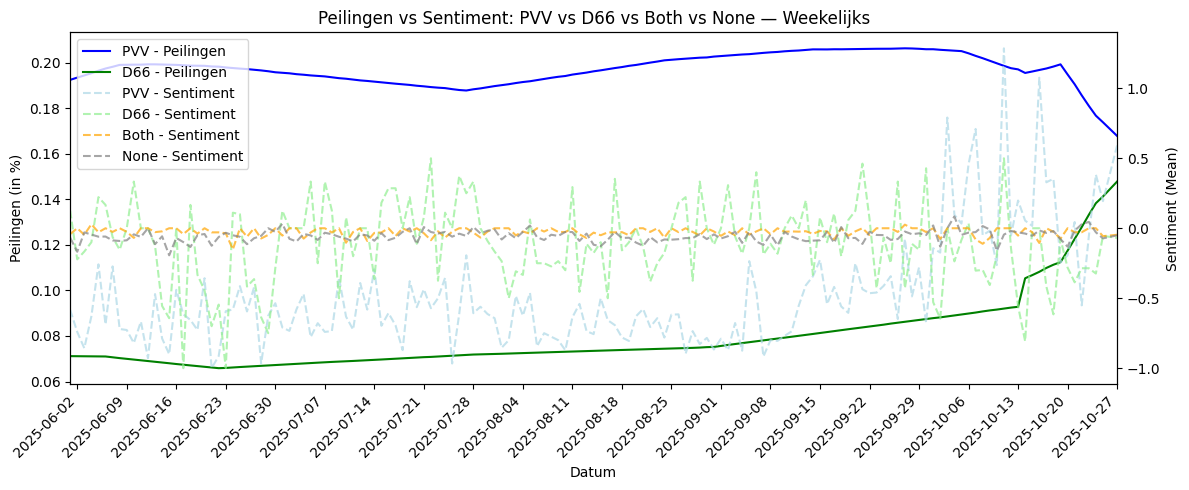

In [14]:
pvv_line = pvv_line.copy()
d66_line = d66_line.copy()
both_line = both_line.copy()
none_line = none_line.copy()

dutch_months = {
    'januari': '01', 'februari': '02', 'maart': '03', 'april': '04',
    'mei': '05', 'juni': '06', 'juli': '07', 'augustus': '08',
    'september': '09', 'oktober': '10', 'november': '11', 'december': '12'
}

def convert_dutch_date(date_str):
    """Convert Dutch date format (e.g., '1 juni') to datetime"""
    parts = date_str.strip().split()
    if len(parts) == 2:
        day, month = parts
        month_num = dutch_months.get(month.lower())
        if month_num:
            return pd.to_datetime(f'2025-{month_num}-{day.zfill(2)}')
    return pd.NaT

# Convert naar datetime
pvv_line.index = pvv_line.index.map(convert_dutch_date)
d66_line.index = d66_line.index.map(convert_dutch_date)
both_line.index = both_line.index.map(convert_dutch_date)
none_line.index = none_line.index.map(convert_dutch_date)


peilingen.index = pd.to_datetime(peilingen.index)

# Zet om naar range
mask = (peilingen.index >= '2025-06-01') & (peilingen.index <= '2025-10-27')
peilingen_filtered = peilingen.loc[mask]
peilingen_filtered = peilingen_filtered[:149]

# Plot party met sentiment on 2nd axis
fig, ax = plt.subplots(figsize=(12, 5))

# 1ste axis - Peilingen
ax.plot(peilingen_filtered.index, peilingen_filtered['PVV'], label='PVV - Peilingen', color='blue')
ax.plot(peilingen_filtered.index, peilingen_filtered['D66'], label='D66 - Peilingen', color='green')

# 2de - Sentiment
ax2 = ax.twinx()
ax2.plot(pvv_line.index, pvv_line, label='PVV - Sentiment', color='lightblue', linestyle='--', alpha=0.7)
ax2.plot(d66_line.index, d66_line, label='D66 - Sentiment', color='lightgreen', linestyle='--', alpha=0.7)
ax2.plot(both_line.index, both_line, label='Both - Sentiment', color='orange', linestyle='--', alpha=0.7)
ax2.plot(none_line.index, none_line, label='None - Sentiment', color='gray', linestyle='--', alpha=0.7)

# date ;o,ots
ax.set_xlim(pd.Timestamp('2025-06-01'), pd.Timestamp('2025-10-27'))


mondays = pd.date_range(start='2025-06-01', end='2025-10-27', freq='W-MON')
ax.set_xticks(mondays)
ax.set_xticklabels([d.strftime('%Y-%m-%d') for d in mondays], rotation=45, ha='right')

# Labels
ax.set_xlabel("Datum")
ax.set_ylabel("Peilingen (in %)")
ax2.set_ylabel("Sentiment (Mean)")
ax.set_title("Peilingen vs Sentiment: PVV vs D66 vs Both vs None — Weekelijks")

# Combine legends from both axes
lines1, labels1 = ax.get_legend_handles_labels()
lines2, labels2 = ax2.get_legend_handles_labels()
ax.legend(lines1 + lines2, labels1 + labels2, loc='upper left')

filepath = 'image/sentiment.png'

# Make sure the directory exists
os.makedirs(os.path.dirname(filepath), exist_ok=True)

# Save figure
plt.savefig(filepath, dpi=300, bbox_inches='tight')
plt.tight_layout()
plt.show()

PVV Sentiment is NOT normally distributed (W=0.8358, p=0.0000)
D66 Sentiment is likely normally distributed (W=0.9857, p=0.1293)
PVV Polling is NOT normally distributed (W=0.9073, p=0.0000)
D66 Polling is NOT normally distributed (W=0.7032, p=0.0000)


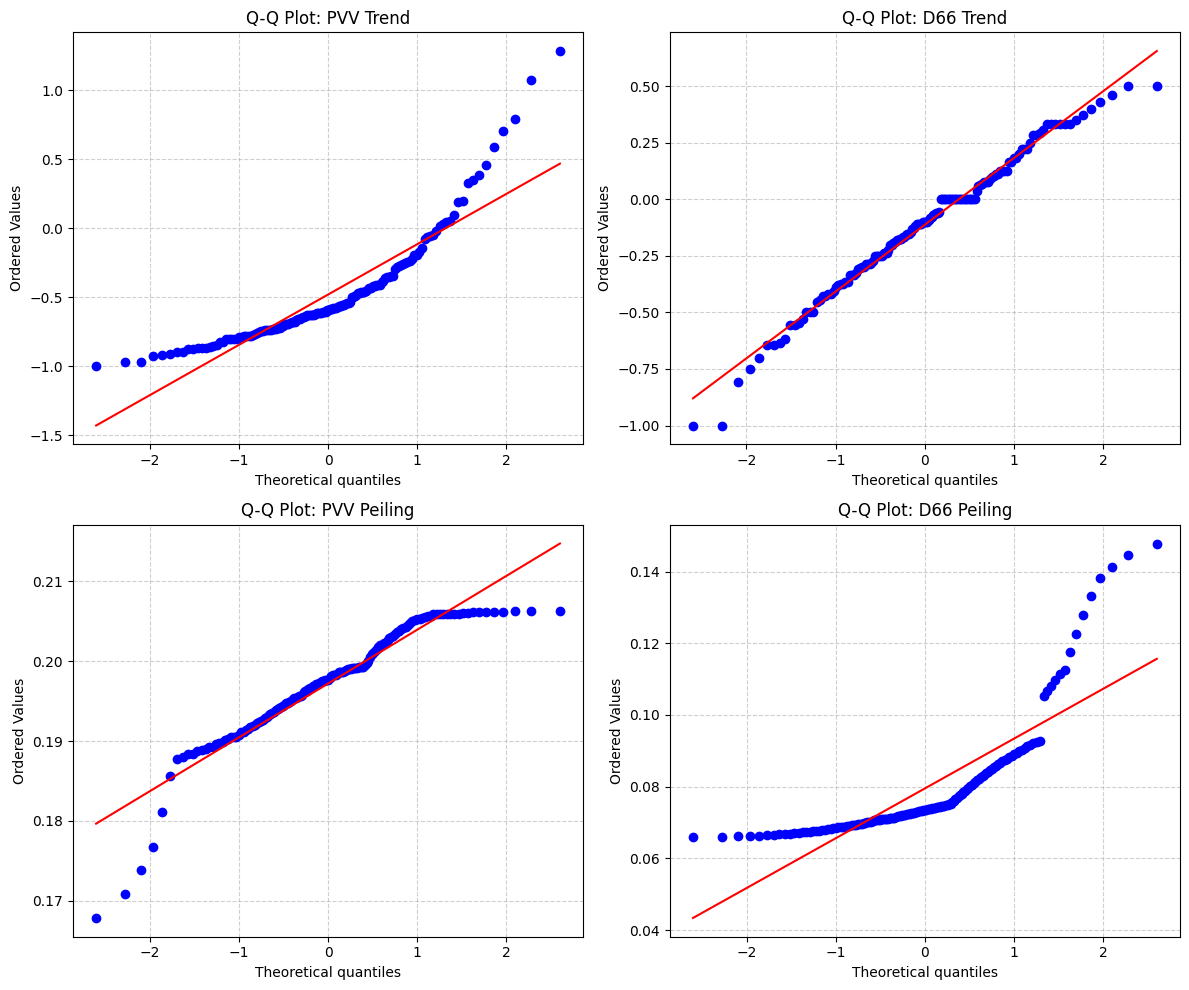

PVV Polling vs Sentiment relationship is NOT monotonic.
D66 Polling vs Sentiment relationship is NOT monotonic.


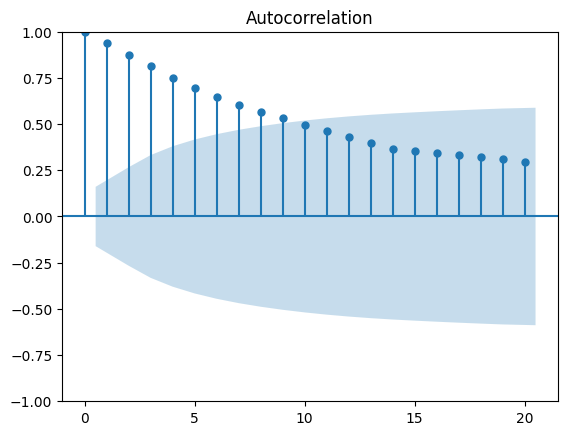

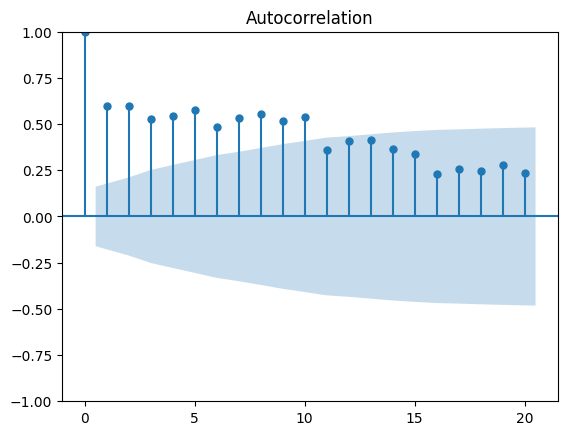

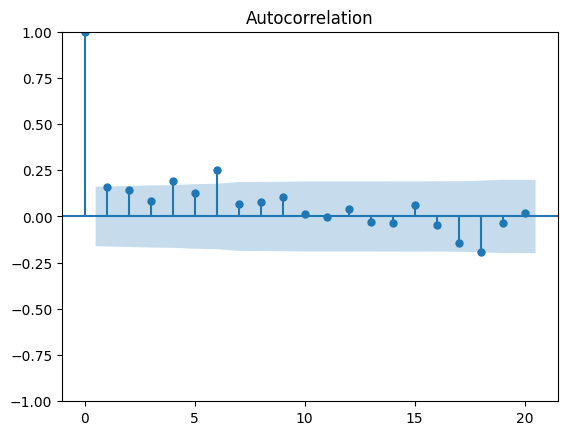

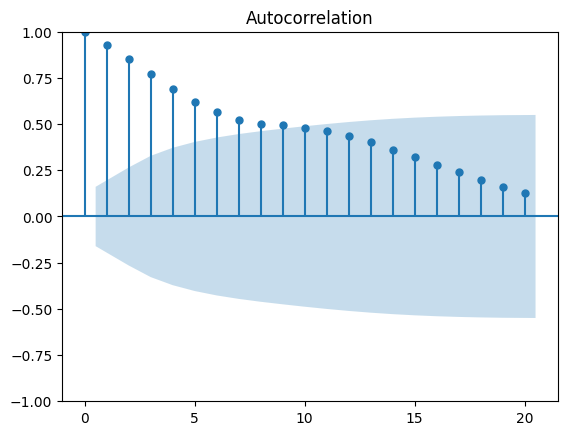

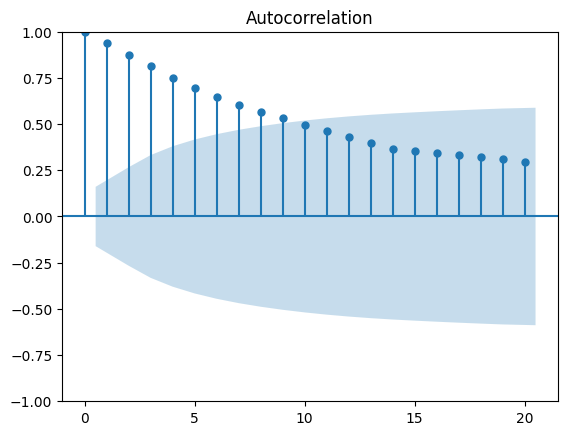

In [15]:
#normaal distributie voor Pearson
pvv_data = pvv_line.dropna()
d66_data = d66_line.dropna()
pvv_poll = peilingen_filtered['PVV'].dropna()
d66_poll = peilingen_filtered['D66'].dropna()

# Shapiro-Wilk test
def normality_test(data, name):
    stat, p = shapiro(data)
    if p > 0.05:
        print(f"{name} is likely normally distributed (W={stat:.4f}, p={p:.4f})")
    else:
        print(f"{name} is NOT normally distributed (W={stat:.4f}, p={p:.4f})")


normality_test(pvv_data, "PVV Sentiment")
normality_test(d66_data, "D66 Sentiment")
normality_test(pvv_poll, "PVV Polling")
normality_test(d66_poll, "D66 Polling")

print('='* 60)

# Lijst met data en titels voor de loop
datasets = [pvv_data, d66_data, pvv_poll, d66_poll]
titles = ["Q-Q Plot: PVV Trend", "Q-Q Plot: D66 Trend", 
          "Q-Q Plot: PVV Peiling", "Q-Q Plot: D66 Peiling"]

# Maak een figure met 2x2 subplots
fig, axes = plt.subplots(2, 2, figsize=(12, 10))
axes = axes.flatten()

for i, data in enumerate(datasets):
    # Genereer de Q-Q plot op het specifieke subplot
    stats.probplot(data, dist="norm", plot=axes[i])
    axes[i].set_title(titles[i])
    axes[i].grid(True, linestyle='--', alpha=0.6)

plt.tight_layout()

# Opslaan voor Overleaf
filepath_qq = r'image/QQ_plots_normaliteit.png'
plt.savefig(filepath_qq, dpi=300, bbox_inches='tight')

plt.show()
#monotonic voor Spearman
def is_monotonic(x, y, name):
    # Remove NaNs
    mask = ~np.isnan(x) & ~np.isnan(y)
    x, y = x[mask], y[mask]

    # Check monotonic increasing or decreasing
    increasing = np.all(np.diff(y[np.argsort(x)]) >= 0)
    decreasing = np.all(np.diff(y[np.argsort(x)]) <= 0)

    if increasing:
        print(f"{name} relationship is monotonic increasing.")
    elif decreasing:
        print(f"{name} relationship is monotonic decreasing.")
    else:
        print(f"{name} relationship is NOT monotonic.")

# Convert to numpy arrays
pvv_sentiment = pvv_line.dropna().reindex(peilingen_filtered.index, method='nearest').values
d66_sentiment = d66_line.dropna().reindex(peilingen_filtered.index, method='nearest').values
pvv_poll = peilingen_filtered['PVV'].dropna().values
d66_poll = peilingen_filtered['D66'].dropna().values

# Check monotonicity
is_monotonic(pvv_poll, pvv_sentiment, "PVV Polling vs Sentiment")
is_monotonic(d66_poll, d66_sentiment, "D66 Polling vs Sentiment")



plot_acf(pvv_data.dropna(), lags=20)
plot_acf(d66_data.dropna(), lags=20)
plot_acf(pvv_poll, lags=20)
plot_acf(d66_poll, lags=20)


## Bereik metadata

In [16]:
frame_party = frame[frame['party_target'].isin(['PVV', 'D66'])]

# Select numeric columns (excluding bot and sentiment)
numeric_cols = ['author/followers', 'author/following', 'bookmarkCount',
                'viewCount', 'retweetCount', 'replyCount', 'quoteCount', 'likeCount']

# Group by party and get descriptive stats
descriptive_stats = frame_party.groupby('party_target')[numeric_cols].describe()

print(descriptive_stats)

# Optional: find party with highest mean reach
mean_reach = frame_party.groupby('party_target')[numeric_cols].mean()
print("\nMean reach by party:\n", mean_reach)

# Determine which party has highest average reach per metric
highest_reach_party = mean_reach.idxmax()
print("\nParty with highest reach per metric:\n", highest_reach_party)

             author/followers                                                 \
                        count         mean           std   min    25%    50%   
party_target                                                                   
D66                    2248.0  1285.037811   5640.399889  29.0  230.0  434.0   
PVV                    6175.0  3773.654575  15401.885261  26.0  266.0  449.0   

                              author/following              ... quoteCount  \
                75%       max            count        mean  ...        75%   
party_target                                                ...              
D66           529.0  108721.0           2248.0  634.166815  ...       83.0   
PVV           664.0  315902.0           6175.0  869.078543  ...       85.0   

                      likeCount                                          \
                  max     count         mean           std   min    25%   
party_target                                              

In [17]:
output_dir = Path(r"data")

output_path = output_dir / "descrip.csv"
descriptive_stats.to_csv(output_path, index=False)

C:\Users\Gebruiker\AppData\Local\Temp\ipykernel_20340\3692695311.py:8: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.boxplot(x='party_target', y='viewCount', data=frame_party, showfliers=False, palette=['lightblue', 'lightgreen'])
C:\Users\Gebruiker\AppData\Local\Temp\ipykernel_20340\3692695311.py:15: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.boxplot(x='party_target', y='likeCount', data=frame_party, showfliers=False, palette=['lightblue', 'lightgreen'])


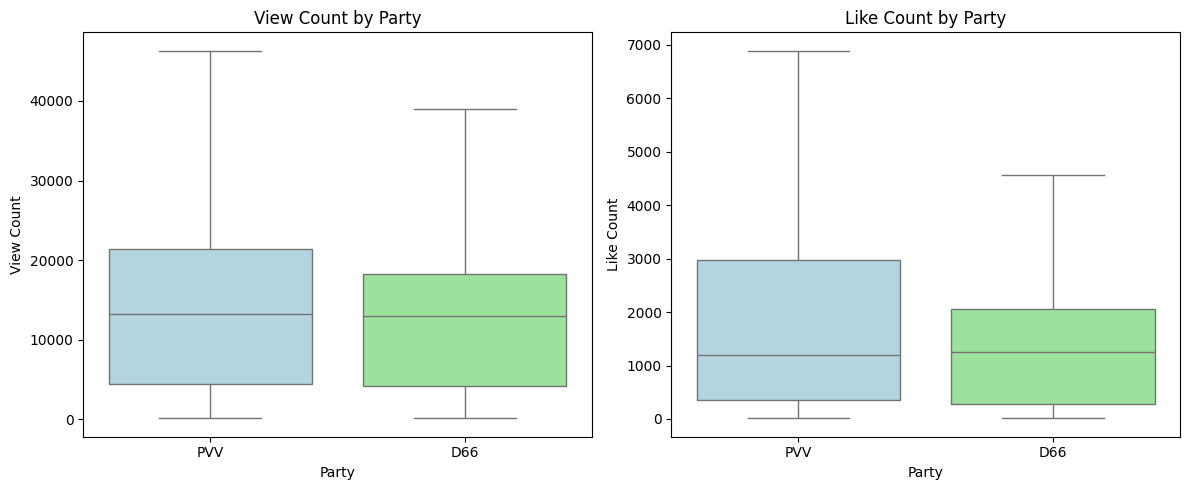

In [18]:
frame_party = frame[frame['party_target'].isin(['PVV', 'D66'])]

# Create separate boxplots for viewCount and likeCount
plt.figure(figsize=(12, 5))

# Boxplot for viewCount
plt.subplot(1, 2, 1)
sns.boxplot(x='party_target', y='viewCount', data=frame_party, showfliers=False, palette=['lightblue', 'lightgreen'])
plt.title('View Count by Party')
plt.ylabel('View Count')
plt.xlabel('Party')

# Boxplot for likeCount
plt.subplot(1, 2, 2)
sns.boxplot(x='party_target', y='likeCount', data=frame_party, showfliers=False, palette=['lightblue', 'lightgreen'])
plt.title('Like Count by Party')
plt.ylabel('Like Count')
plt.xlabel('Party')

filepath = r'image/1-descriptive.png'

# Make sure the directory exists
os.makedirs(os.path.dirname(filepath), exist_ok=True)

# Save figure
plt.savefig(filepath, dpi=300, bbox_inches='tight')

plt.tight_layout()
plt.show()

C:\Users\Gebruiker\AppData\Local\Temp\ipykernel_20340\3565402263.py:11: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.boxplot(x='party_target', y=metric, data=frame_party, showfliers=False, palette=['lightblue', 'lightgreen'])
C:\Users\Gebruiker\AppData\Local\Temp\ipykernel_20340\3565402263.py:11: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.boxplot(x='party_target', y=metric, data=frame_party, showfliers=False, palette=['lightblue', 'lightgreen'])
C:\Users\Gebruiker\AppData\Local\Temp\ipykernel_20340\3565402263.py:11: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns

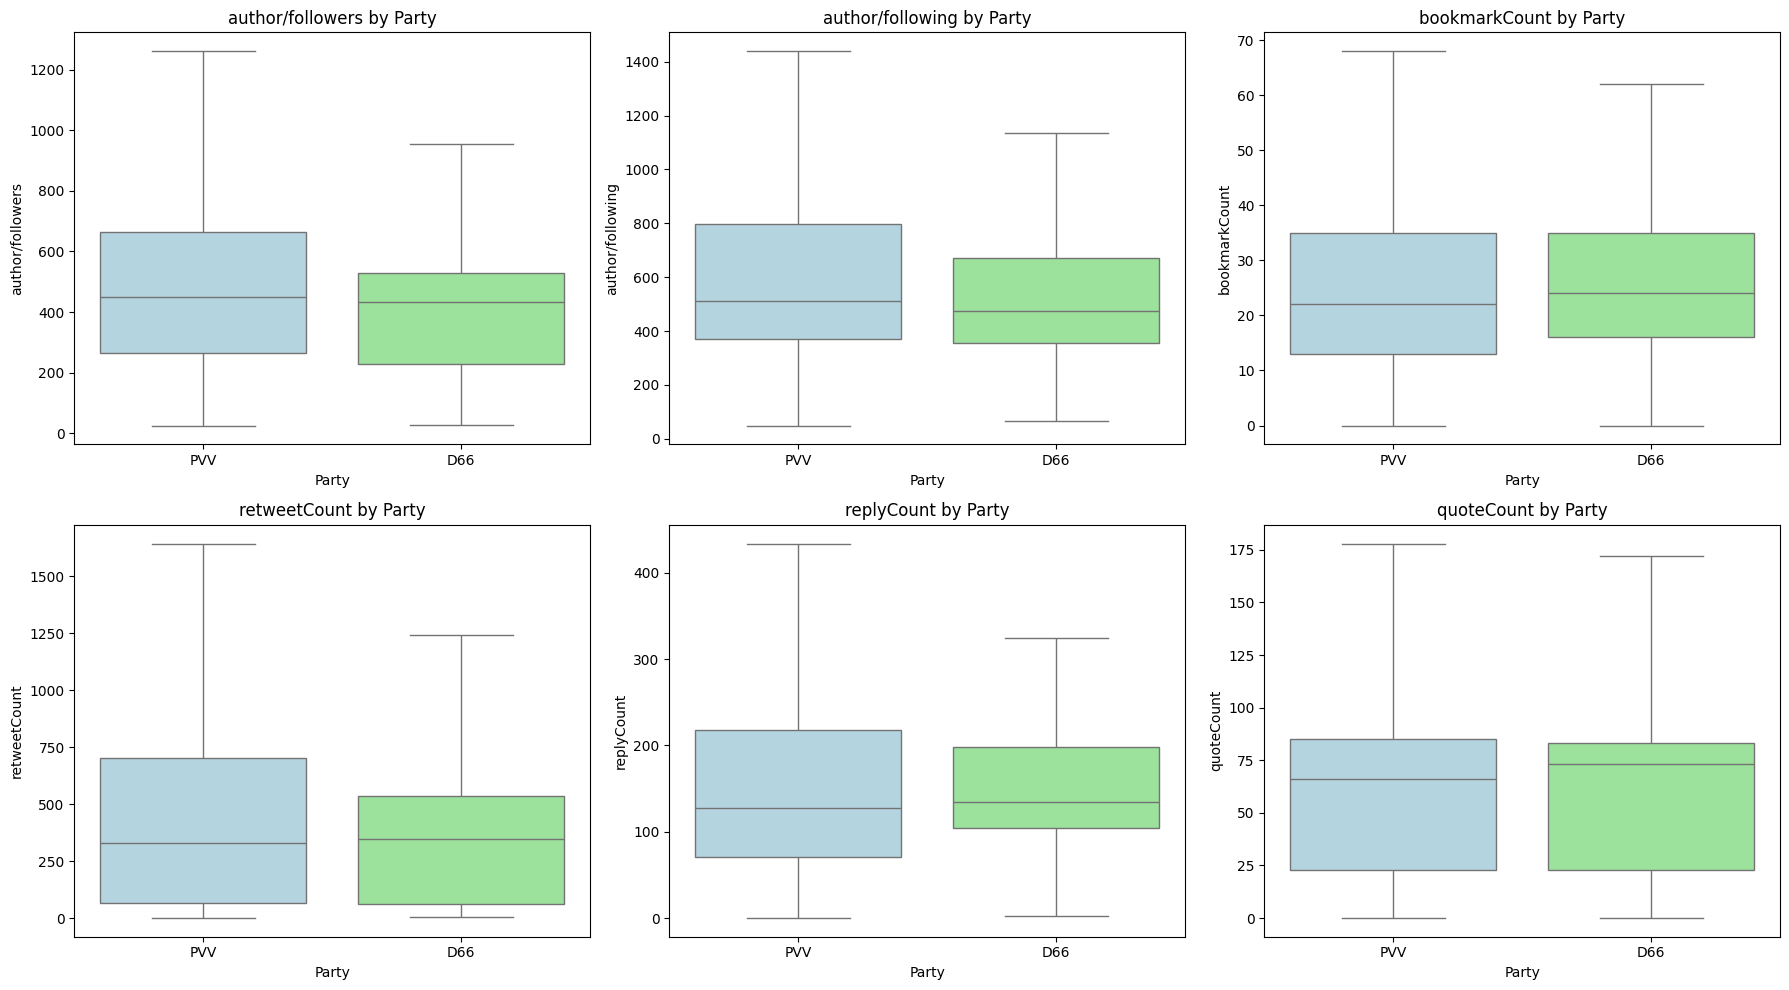

In [19]:
frame_party = frame[frame['party_target'].isin(['PVV', 'D66'])]

# Metrics to plot (excluding viewCount and likeCount)
other_metrics = ['author/followers', 'author/following', 'bookmarkCount',
                 'retweetCount', 'replyCount', 'quoteCount']

# Create boxplots for the other metrics
plt.figure(figsize=(18, 10))
for i, metric in enumerate(other_metrics, 1):
    plt.subplot(2, 3, i)
    sns.boxplot(x='party_target', y=metric, data=frame_party, showfliers=False, palette=['lightblue', 'lightgreen'])
    plt.title(f'{metric} by Party')
    plt.xlabel('Party')
    plt.ylabel(metric)


filepath = r'image/2-descriptive.png'

# Make sure the directory exists
os.makedirs(os.path.dirname(filepath), exist_ok=True)

# Save figure
plt.savefig(filepath, dpi=300, bbox_inches='tight')
plt.tight_layout()
plt.show()

In [20]:
# ensure sentiment is numeric
frame["sentiment"] = pd.to_numeric(frame["sentiment"], errors="coerce")

# --- total tweets ---
total_tweets = len(frame)

# --- all PVV tweets ---
pvv_df = frame[frame["party_target"] == "PVV"]

# --- count ---
pvv_count = len(pvv_df)

# --- mean sentiment of PVV tweets ---
mean_sent_pvv = pvv_df["sentiment"].mean()

# --- transform sentiment to multiplier ---
sentiment_multiplier = 1 + mean_sent_pvv

# --- final score ---
score_all = ((pvv_count * sentiment_multiplier) / total_tweets) * 100

print(f"Bereikscore PVV: {score_all}")

Bereikscore PVV: 13.882443928847641


In [21]:
# ensure sentiment is numeric
frame["sentiment"] = pd.to_numeric(frame["sentiment"], errors="coerce")

# --- total tweets ---
total_tweets = len(frame)

# --- all D66 tweets ---
d66_df = frame[frame["party_target"] == "D66"]

# --- count ---
d66_count = len(d66_df)

# --- mean sentiment of D66 tweets ---
mean_sent_d66 = d66_df["sentiment"].mean()

# --- transform sentiment to multiplier ---
sentiment_multiplier_d66 = 1 + mean_sent_d66

# --- final score ---
score_all_d66 = ((d66_count * sentiment_multiplier_d66) / total_tweets) * 100

print(f"Bereikscore D66: {score_all_d66}")


Bereikscore D66: 5.893915957721061


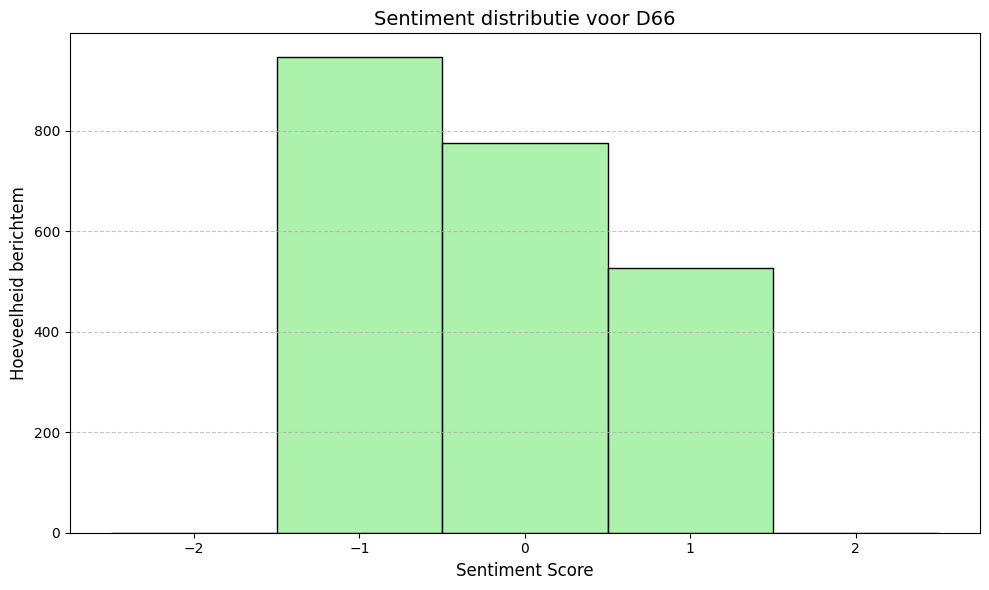

In [22]:
d66_plot_df = frame[frame["party_target"] == "D66"].dropna(subset=["sentiment"])

# 2. Create the plot
plt.figure(figsize=(10, 6))

# We use bins to ensure the bars center on -2, -1, 0, 1, and 2
# Bin edges are set halfway between the integers
bins = [-2.5, -1.5, -0.5, 0.5, 1.5, 2.5]

sns.histplot(d66_plot_df["sentiment"], bins=bins, kde=False, color='lightgreen', edgecolor='black')

# 3. Formatting the axes
plt.title("Sentiment distributie voor D66", fontsize=14)
plt.xlabel("Sentiment Score", fontsize=12)
plt.ylabel("Hoeveelheid berichtem", fontsize=12)
plt.xticks([-2, -1, 0, 1, 2])  # Force the x-axis to show only these labels
plt.grid(axis='y', linestyle='--', alpha=0.7)

filepath = r'image/Sentiment distributie D66.png'

# Make sure the directory exists
os.makedirs(os.path.dirname(filepath), exist_ok=True)

# Save figure
plt.savefig(filepath, dpi=300, bbox_inches='tight')

plt.tight_layout()
plt.show()

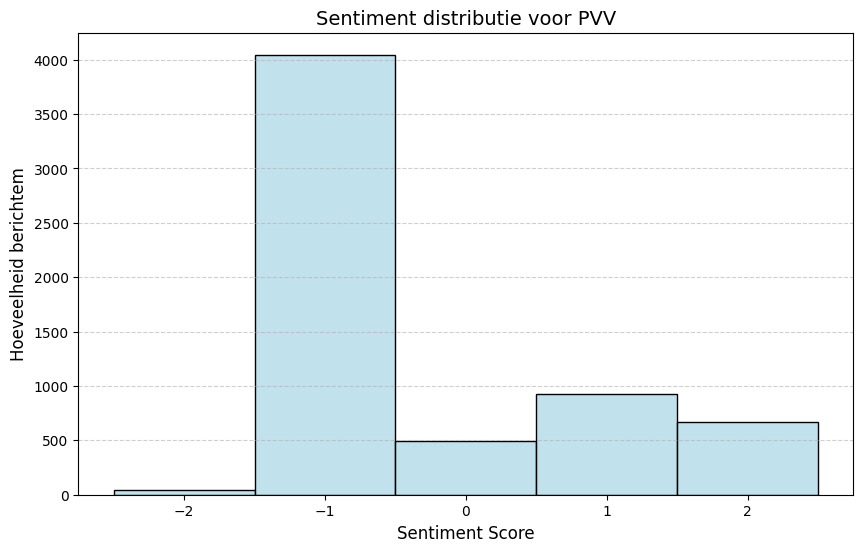

In [23]:
frame["sentiment"] = pd.to_numeric(frame["sentiment"], errors="coerce")

# 2. Filter for PVV
pvv_df = frame[frame["party_target"] == "PVV"]

# --- Histogram Visualization ---
plt.figure(figsize=(10, 6))

# Define bins so that bars are centered on -2, -1, 0, 1, 2
bins = [-2.5, -1.5, -0.5, 0.5, 1.5, 2.5]

sns.histplot(pvv_df["sentiment"].dropna(), bins=bins, kde=False, color='lightblue', edgecolor='black')

plt.title("Sentiment distributie voor PVV", fontsize=14)
plt.xlabel("Sentiment Score", fontsize=12)
plt.ylabel("Hoeveelheid berichtem", fontsize=12)
plt.xticks([-2, -1, 0, 1, 2])  # Ensures all requested points are visible
plt.grid(axis='y', linestyle='--', alpha=0.6)

filepath = r'image/Sentiment distributie PVV.png'

# Make sure the directory exists
os.makedirs(os.path.dirname(filepath), exist_ok=True)

# Save figure
plt.savefig(filepath, dpi=300, bbox_inches='tight')

plt.show()

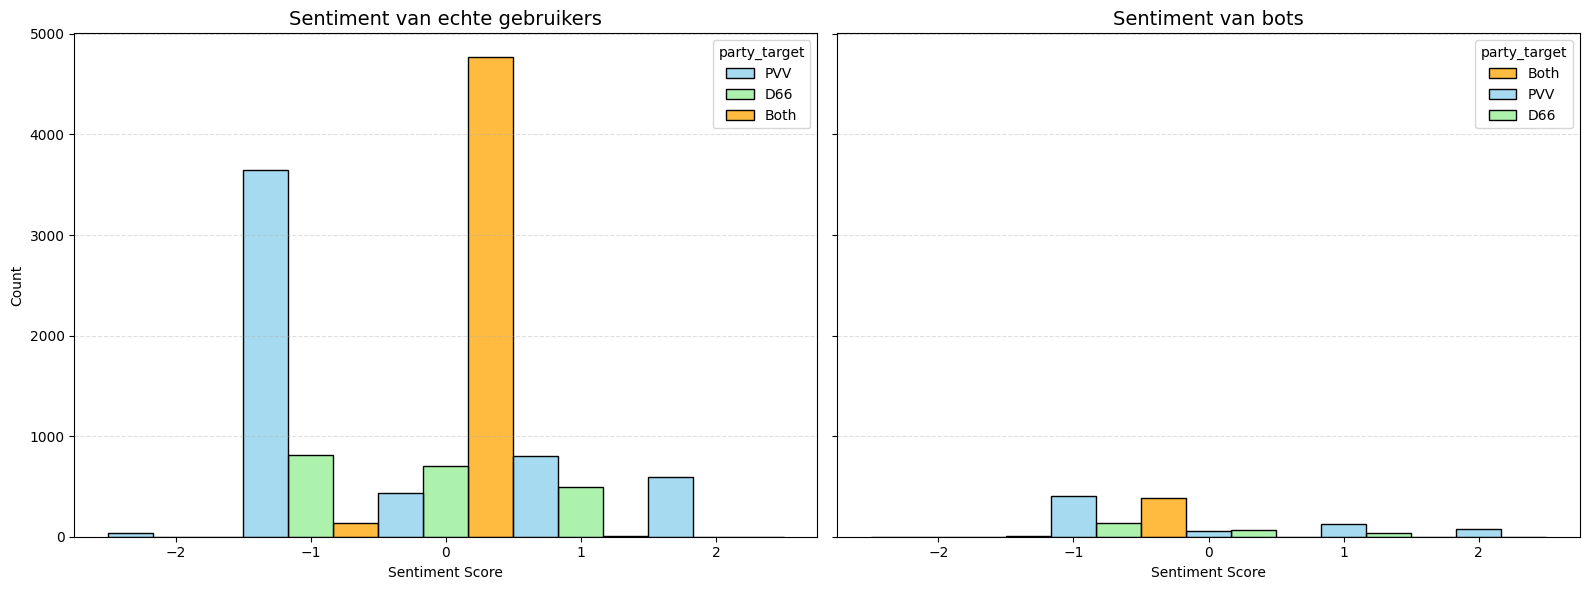

In [24]:
frame["sentiment"] = pd.to_numeric(frame["sentiment"], errors="coerce")

# 2. Definieer de specifieke kleuren zoals gevraagd
color_map = {
    "PVV": "skyblue",      # Lichtblauw
    "D66": "lightgreen",   # Lichtgroen
    "None": "darkgray",    # Grijs
    "Both": "orange"         # Roze
}

# 3. Maak de figure aan met twee subplots
fig, axes = plt.subplots(1, 2, figsize=(16, 6), sharey=True)
bins = [-2.5, -1.5, -0.5, 0.5, 1.5, 2.5]

# --- Histogram voor Echte mensen (bot == 0) ---
sns.histplot(data=frame[frame["bot"] == 0], x="sentiment", hue="party_target", 
             bins=bins, multiple="dodge", ax=axes[0], palette=color_map)
axes[0].set_title("Sentiment van echte gebruikers", fontsize=14)
axes[0].set_xticks([-2, -1, 0, 1, 2])
axes[0].set_xlabel("Sentiment Score")
axes[0].grid(axis='y', linestyle='--', alpha=0.4)

# --- Histogram voor Bots (bot == 1) ---
sns.histplot(data=frame[frame["bot"] == 1], x="sentiment", hue="party_target", 
             bins=bins, multiple="dodge", ax=axes[1], palette=color_map)
axes[1].set_title("Sentiment van bots", fontsize=14)
axes[1].set_xticks([-2, -1, 0, 1, 2])
axes[1].set_xlabel("Sentiment Score")
axes[1].grid(axis='y', linestyle='--', alpha=0.4)

filepath = r'image/Sentiment distributie Echt vs Bot.png'

# Make sure the directory exists
os.makedirs(os.path.dirname(filepath), exist_ok=True)

# Save figure
plt.savefig(filepath, dpi=300, bbox_inches='tight')

plt.tight_layout()
plt.show()

In [25]:
# Bereken gemiddelde sentiment per groep (Mens vs Bot)
means = frame.groupby('bot')['sentiment'].mean()

print(f"Gemiddeld sentiment Echte gebruikers (bot=0): {means[0]:.4f}")
print(f"Gemiddeld sentiment Bots (bot=1):             {means[1]:.4f}")

# Optioneel: Gemiddelde per partij én per bot-status
party_bot_means = frame.groupby(['party_target', 'bot'])['sentiment'].mean().unstack()
print("\nGemiddelde per partij target:")
print(party_bot_means)

Gemiddeld sentiment Echte gebruikers (bot=0): -0.1086
Gemiddeld sentiment Bots (bot=1):             -0.1182

Gemiddelde per partij target:
bot                  0         1
party_target                    
Both         -0.027506 -0.012626
D66          -0.160359 -0.404167
PVV          -0.313406 -0.209160


In [26]:
# Functie om dCor te berekenen voor een specifieke partij
def calculate_party_dcor(sentiment_series, poll_series, party_name):
    # 1. Samenvoegen op basis van de datum-index (inner join)
    combined = pd.concat([sentiment_series, poll_series], axis=1).dropna()
    combined.columns = ['sentiment', 'poll']
    
    # 2. dCor berekenen
    distance_corr = dcor.distance_correlation(combined['sentiment'], combined['poll'])
    
    print(f"--- {party_name} ---")
    print(f"Aantal datapunten na alignatie: {len(combined)}")
    print(f"Distance Correlation: {distance_corr:.4f}\n")
    return distance_corr

# Uitvoeren voor PVV en D66
dcor_pvv = calculate_party_dcor(pvv_line, peilingen_filtered['PVV'], "PVV")
dcor_d66 = calculate_party_dcor(d66_line, peilingen_filtered['D66'], "D66")

--- PVV ---
Aantal datapunten na alignatie: 148
Distance Correlation: 0.2144

--- D66 ---
Aantal datapunten na alignatie: 148
Distance Correlation: 0.2154



# Zoektermen 

## Dataprep

In [27]:
frame = pd.read_csv(r'data/bot_ml.csv')

In [28]:
# Nederlandse maanden
maanden = {
    'januari': '01', 'februari': '02', 'maart': '03', 'april': '04',
    'mei': '05', 'juni': '06', 'juli': '07', 'augustus': '08',
    'september': '09', 'oktober': '10', 'november': '11', 'december': '12'
}

# createdAt omzetten naar echte datum (YYYY-MM-DD)
def parse_dutch_date(x):
    if pd.isna(x):
        return pd.NaT
    try:
        dag, maand = x.lower().split()
        maand = maanden.get(maand)
        if maand is None:
            return pd.NaT
        return pd.to_datetime(f"2025-{maand}-{int(dag):02d}")
    except:
        return pd.NaT

frame['createdAt_parsed'] = frame['createdAt'].apply(parse_dutch_date)

In [29]:
# Zoektermen 1 - Kabinet vallen
pattern = re.compile(r'\b(val|vallen|gevallen)\b', flags=re.IGNORECASE)

# Periodes
start_1, end_1 = pd.Timestamp('2025-06-01'), pd.Timestamp('2025-06-03')
start_2, end_2 = pd.Timestamp('2025-06-04'), pd.Timestamp('2025-06-08')

# Tellen
resultaat = {
    '1–3 juni': frame.loc[
        frame['createdAt_parsed'].between(start_1, end_1),
        'fullText'
    ].astype(str).str.contains(pattern).sum(),

    '4–8 juni': frame.loc[
        frame['createdAt_parsed'].between(start_2, end_2),
        'fullText'
    ].astype(str).str.contains(pattern).sum()
}

print(resultaat)

{'1–3 juni': np.int64(4), '4–8 juni': np.int64(16)}


C:\Users\Gebruiker\AppData\Local\Temp\ipykernel_20340\4101290914.py:13: UserWarning: This pattern is interpreted as a regular expression, and has match groups. To actually get the groups, use str.extract.
  ].astype(str).str.contains(pattern).sum(),
C:\Users\Gebruiker\AppData\Local\Temp\ipykernel_20340\4101290914.py:18: UserWarning: This pattern is interpreted as a regular expression, and has match groups. To actually get the groups, use str.extract.
  ].astype(str).str.contains(pattern).sum()


In [30]:
# Zoektermen 2 - Gaza protesten, rode lijn
pattern = re.compile(
    r'\b(gaza|palestina|israel|isreal|rode\s+lijn|protest)\b',
    flags=re.IGNORECASE
)

# Referentiedatum
referentie = pd.Timestamp('2025-06-15')

# Periodes (exclusief 15 juni)
start_voor = referentie - pd.Timedelta(days=5)   # 10 juni
end_voor   = referentie - pd.Timedelta(days=1)   # 14 juni

start_na   = referentie + pd.Timedelta(days=1)   # 16 juni
end_na     = referentie + pd.Timedelta(days=5)   # 20 juni

# Tellen
resultaat = {
    '10–14 juni (voor)': frame.loc[
        frame['createdAt_parsed'].between(start_voor, end_voor),
        'fullText'
    ].astype(str).str.contains(pattern).sum(),

    '16–20 juni (na)': frame.loc[
        frame['createdAt_parsed'].between(start_na, end_na),
        'fullText'
    ].astype(str).str.contains(pattern).sum()
}

print(resultaat)

{'10–14 juni (voor)': np.int64(0), '16–20 juni (na)': np.int64(6)}


C:\Users\Gebruiker\AppData\Local\Temp\ipykernel_20340\2249288437.py:22: UserWarning: This pattern is interpreted as a regular expression, and has match groups. To actually get the groups, use str.extract.
  ].astype(str).str.contains(pattern).sum(),
C:\Users\Gebruiker\AppData\Local\Temp\ipykernel_20340\2249288437.py:27: UserWarning: This pattern is interpreted as a regular expression, and has match groups. To actually get the groups, use str.extract.
  ].astype(str).str.contains(pattern).sum()


In [31]:
# Zoektermen 3 - NSC minsters stappen op na Isreal sanctiedebat
pattern = re.compile(
    r'\b(NSC|opstappen|stapt\s+op|sanctie|israel|minister)\b',
    flags=re.IGNORECASE
)

# Referentiedatum
referentie = pd.Timestamp('2025-08-22')

# Periodes (exclusief 22 augustus)
start_voor = referentie - pd.Timedelta(days=5)  # 17 augustus
end_voor   = referentie - pd.Timedelta(days=1)  # 21 augustus

start_na   = referentie + pd.Timedelta(days=1)  # 23 augustus
end_na     = referentie + pd.Timedelta(days=5)  # 27 augustus

# Tellen
resultaat = {
    '17–21 augustus (voor)': frame.loc[
        frame['createdAt_parsed'].between(start_voor, end_voor),
        'fullText'
    ].astype(str).str.contains(pattern).sum(),

    '23–27 augustus (na)': frame.loc[
        frame['createdAt_parsed'].between(start_na, end_na),
        'fullText'
    ].astype(str).str.contains(pattern).sum()
}

print(resultaat)


{'17–21 augustus (voor)': np.int64(18), '23–27 augustus (na)': np.int64(16)}


C:\Users\Gebruiker\AppData\Local\Temp\ipykernel_20340\2233428955.py:22: UserWarning: This pattern is interpreted as a regular expression, and has match groups. To actually get the groups, use str.extract.
  ].astype(str).str.contains(pattern).sum(),
C:\Users\Gebruiker\AppData\Local\Temp\ipykernel_20340\2233428955.py:27: UserWarning: This pattern is interpreted as a regular expression, and has match groups. To actually get the groups, use str.extract.
  ].astype(str).str.contains(pattern).sum()


In [32]:
# Zoektermen 4 – Lijsttrekkersdebatten en campagnepiek
pattern = re.compile(
    r'\b(lijsttrekker|campagne|debat|geert|wilders|rob|jetten)\b',
    flags=re.IGNORECASE
)

# Referentiedatum
referentie = pd.Timestamp('2025-10-01')

# Periodes (5 dagen voor en na, exclusief 1 oktober)
start_voor = referentie - pd.Timedelta(days=5)  # 26 september
end_voor   = referentie - pd.Timedelta(days=1)  # 30 september

start_na   = referentie + pd.Timedelta(days=1)  # 2 oktober
end_na     = referentie + pd.Timedelta(days=5)  # 6 oktober

# Tellen
resultaat = {
    '26–30 september (voor)': frame.loc[
        frame['createdAt_parsed'].between(start_voor, end_voor),
        'fullText'
    ].astype(str).str.contains(pattern).sum(),

    '2–6 oktober (na)': frame.loc[
        frame['createdAt_parsed'].between(start_na, end_na),
        'fullText'
    ].astype(str).str.contains(pattern).sum()
}

print(resultaat)


{'26–30 september (voor)': np.int64(70), '2–6 oktober (na)': np.int64(280)}


C:\Users\Gebruiker\AppData\Local\Temp\ipykernel_20340\2266390301.py:22: UserWarning: This pattern is interpreted as a regular expression, and has match groups. To actually get the groups, use str.extract.
  ].astype(str).str.contains(pattern).sum(),
C:\Users\Gebruiker\AppData\Local\Temp\ipykernel_20340\2266390301.py:27: UserWarning: This pattern is interpreted as a regular expression, and has match groups. To actually get the groups, use str.extract.
  ].astype(str).str.contains(pattern).sum()


In [33]:
# Zoektermen 5 – Slotstuk
pattern = re.compile(
    r'\b(verkiezingsdag|ik\s+stem|stem\s+op|kies|kies\s+voor)\b',
    flags=re.IGNORECASE
)

# Referentiedatum
referentie = pd.Timestamp('2025-10-21')

# Periodes (5 dagen voor en na, exclusief 21 oktober)
start_voor = referentie - pd.Timedelta(days=5)  # 16 oktober
end_voor   = referentie - pd.Timedelta(days=1)  # 20 oktober

start_na   = referentie + pd.Timedelta(days=1)  # 22 oktober
end_na     = referentie + pd.Timedelta(days=5)  # 26 oktober

# Tellen
resultaat = {
    '16–20 oktober (voor)': frame.loc[
        frame['createdAt_parsed'].between(start_voor, end_voor),
        'fullText'
    ].astype(str).str.contains(pattern).sum(),

    '22–26 oktober (na)': frame.loc[
        frame['createdAt_parsed'].between(start_na, end_na),
        'fullText'
    ].astype(str).str.contains(pattern).sum()
}

print(resultaat)


{'16–20 oktober (voor)': np.int64(0), '22–26 oktober (na)': np.int64(1)}


C:\Users\Gebruiker\AppData\Local\Temp\ipykernel_20340\3434919650.py:22: UserWarning: This pattern is interpreted as a regular expression, and has match groups. To actually get the groups, use str.extract.
  ].astype(str).str.contains(pattern).sum(),
C:\Users\Gebruiker\AppData\Local\Temp\ipykernel_20340\3434919650.py:27: UserWarning: This pattern is interpreted as a regular expression, and has match groups. To actually get the groups, use str.extract.
  ].astype(str).str.contains(pattern).sum()
